In [ ]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Regresion Lineal

Para este set de datos

In [ ]:
# Nuevo set de datos (esta vez, hago dos copias)
x_ = np.random.rand(20, 1)
t_ = np.sin(2*np.pi*x_) + np.random.randn(len(x_), 1) * 0.3

# Antes que nada, voy a separar en conjunto de entrenamiento y de testeo
x_train, x_test = x_[:10], x_[10:]
t_train, t_test = t_[:10], t_[10:]

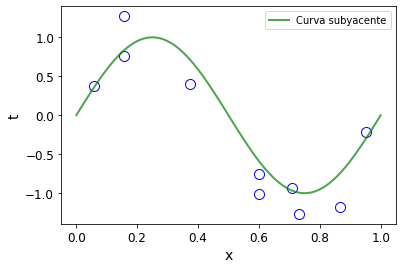

In [ ]:
# Array para plotear
xx = np.linspace(0, 1, 100).reshape([-1, 1])

def plot_data_sine(x, t, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(x, t, 'ob', mfc='None', ms=10)
    ax.plot(xx, np.sin(2*np.pi * xx), 'g-', lw=2, alpha=0.7, label='Curva subyacente')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.legend(loc=0)
    return

plot_data_sine(x_train, t_train)

Utilicen `sklearn` para ajustar polinomios de orden 1, 2, ..., 11 a los datos de entrenamiento. Definan una metrica RMSE de evaluacion en entrenamiento y en testeo.  Grafiquen en una misma figura la dependencia de esta metrica en entrenamiento y en testeo en funcion del grado del polinomio. En tres figuras distintas grafiquen la curva verdadera y la curva predicha por los modelos con grado 1, 11 y el mejor segun las metricas evaluadas.

**Pista:** Inicialicen `PolynomialFeatures()` sin especificar el grado y, en un loop, pueden settearlo con `modelo.named_steps[nombre adecuado].degree=grado`

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import Pipeline
from sklearn.preprocessing  import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [ ]:
# Creo el modelo
modelo = Pipeline([('poly',PolynomialFeatures()),('regressor',LinearRegression(fit_intercept=False))])

def metrica(t,y):
  return np.sqrt(mse(t,y))

# Inicializo listas
grados = np.arange(1,12,1)
coeficientes = []
metrica_entrenamiento = []
metrica_testeo = []
predicciones = []

# Itero sobre los grados
for grado in grados:
  modelo['poly'].degree = grado
  modelo.fit(x_train,t_train)
  coeficientes.append(modelo['regressor'].coef_)
  predicciones.append(modelo.predict(xx))
  metrica_entrenamiento.append(metrica(t_train,modelo.predict(x_train)))
  metrica_testeo.append(metrica(t_test,modelo.predict(x_test)))

1 0.5138278533264234 0.704882957029713
2 0.4535727624425297 0.7881204425029278
3 0.17676743804959566 0.27300173540844813
4 0.17503847652169097 0.2682931462822052
5 0.15907779006006872 0.28851242964658186
6 0.14294872017943663 0.36939982642525654
7 0.12296860144090023 5.487998867482539
8 0.09913022130546016 242.20429544432034
9 2.60430283385176e-08 2026.310465577526
10 1.194785831116607e-08 1833.7799572294257
11 9.4182394620765e-09 1694.8054995376904


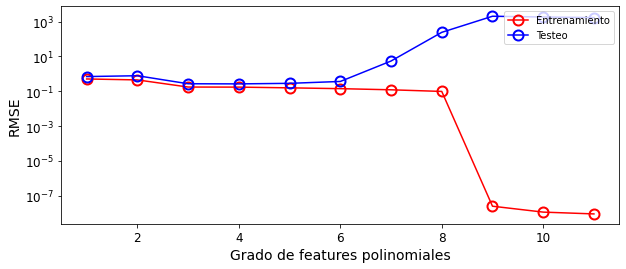

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(grados, metrica_entrenamiento, 'o-r', mfc='None', ms=10, mew=2, label='Entrenamiento')
plt.plot(grados, metrica_testeo, 'o-b', mfc='None', ms=10, mew=2,label='Testeo')
plt.xlabel('Grado de features polinomiales')
plt.ylabel('RMSE')
plt.yscale('log')
plt.legend(loc='upper right')
for i, d in enumerate(grados):
    print(d, metrica_entrenamiento[i], metrica_testeo[i])

grado: 1


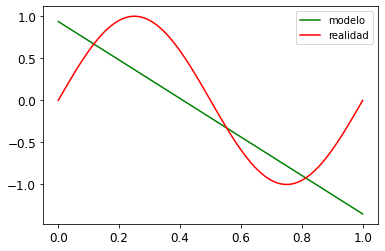

grado: 11


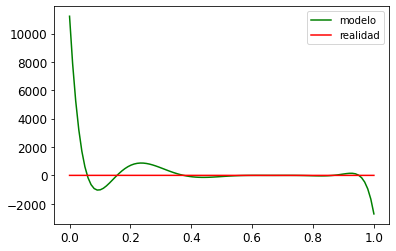

grado: 4


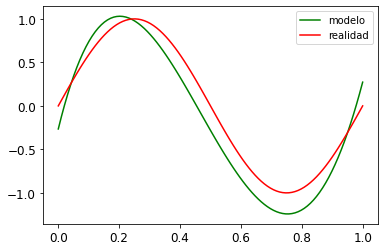

In [ ]:
for i in [0,-1,3]:
  plt.figure()
  print(f"grado:",grados[i])
  plt.plot(xx,predicciones[i],"g",label="modelo")
  plt.plot(xx,np.sin(2*np.pi * xx),"r",label="realidad")
  plt.legend()
  plt.show()

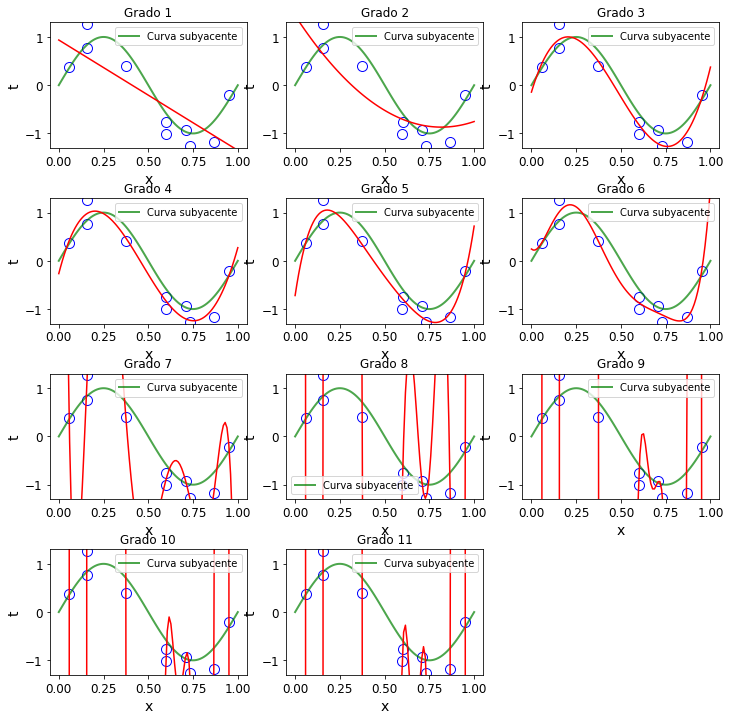

In [ ]:
ncols = 3
nrows = np.int(np.ceil(len(grados)/ncols))

fig = plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.4)

for i, d in enumerate(grados):
    ax = fig.add_subplot(nrows, ncols, i+1)
    plot_data_sine(x_train, t_train, ax=ax)
    ax.plot(xx, predicciones[i], 'r-', label='Prediction')
    ax.set_ylim(-1.3, 1.3)
    ax.set_title('Grado {}'.format(d))

# Validacion cruzada

## Volvamos ahora al problema del overfitting.

Como vimos, cuando aumentamos el grado del polinomio observamos que habia un sobreajuste. La pregunta es como cuantificar esto sin tener que ir al conjunto de test.

Una opcion, la primera y que vamos a reutilizar con Deep Learning, es separar el conjunto de entrenamiento en un subconjunto de verdadero entrenamiento y otro de validacion. Como convencion, tomamos el 20%.

In [ ]:
x_train_2, x_val = x_train[:9], x_train[9:]
t_train_2, t_val = t_train[:9], t_train[9:]

Y entonces entrenamos cada polinomio en train_2 y evaluamos en val

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Creo el pipeline
pp_sine = Pipeline([('poly', PolynomialFeatures()),
                     ('lr', LinearRegression(fit_intercept=False))])

# Inicializo listas
degrees = [1, 2, 3, 5, 7, 9, 11]
coeffs = []
rmse = []
rmse_val = []
preds = []
# Itero sobre los grados
for d in degrees:
    # Fijo el grado
    pp_sine.named_steps['poly'].degree = d
    
    # Fiteo (y registro los valores de los parámetros)
    pp_sine.fit(x_train_2, t_train_2)
    coeffs.append(pp_sine.named_steps['lr'].coef_)
    
    # Obtengo predicciones
    y_train_2 = pp_sine.predict(x_train_2)
    y_val = pp_sine.predict(x_val)
    preds.append(pp_sine.predict(xx))

    # Calculo el RMSE    
    rmse.append(np.sqrt(mse(t_train_2, y_train_2)))
    rmse_val.append(np.sqrt(mse(t_val, y_val)))

1 0.5341393528022618 0.29013020995769645
2 0.4765668703928377 0.12671604412727622
3 0.15068311685812424 0.38259655351353605
5 0.13776574271225495 0.34416472459780567
7 0.11672994888633657 1.740776155165482
9 3.844574261437194e-09 26.104228575988248
11 1.8680058352756635e-09 50.226780182706


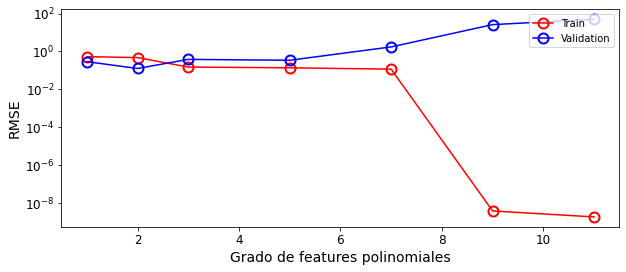

In [ ]:
# Veamos cómo evoluciona la métrica con el número de grados de libertad
plt.figure(figsize=(10,4))
plt.plot(degrees, rmse, 'o-r', mfc='None', ms=10, mew=2, label='Train')
plt.plot(degrees, rmse_val, 'o-b', mfc='None', ms=10, mew=2,label='Validation')
plt.xlabel('Grado de features polinomiales')
plt.ylabel('RMSE')
plt.yscale('log')
plt.legend(loc='upper right')
for i, d in enumerate(degrees):
    print(d, rmse[i], rmse_val[i])

Pero... puedo confiar en esta medida de validacion?

La verdad es que no, tengo pocos datos. Estoy calculando RMSE utilizando unicamente 2 mediciones. 

Si lo pensamos dos segundos, estamos desaprovechando datos. Para eso, y en particular cuando se tiene pocos datos y no toma demasiado tiempo la evaluacion del modelo, se utiliza la **validacion cruzada**.

## Validacion cruzada y K-Folding

La validacion cruzada por K-Folding consiste en divdir los datos en K particiones. Luego, se seleccionan K-1 de esas particiones y se entrena el modelo. Luego, se evalua en la particion restante. Esto se hace para cada una de las K combinaciones posibles y se hace estadistica sobre la evaluacion de validacion.

En particular, el mejor modelo es aquel cuya media es menor. La desviacion estandar da una idea de la incerteza de la metrica.

Cuando se tiene pocos datos, se pueden usar directamente $N$ particiones. Esto es lo que se denomina **Leave-One-Out Cross-Validation (LOO-CV)** 

Estas tecnicas estan incorporadas en `sklearn.model_selection.cross_val_score`.

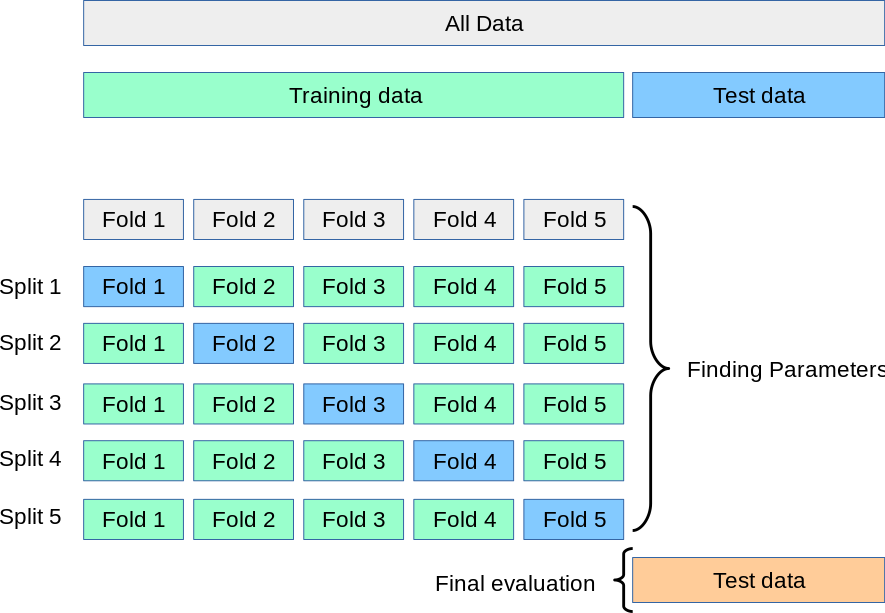

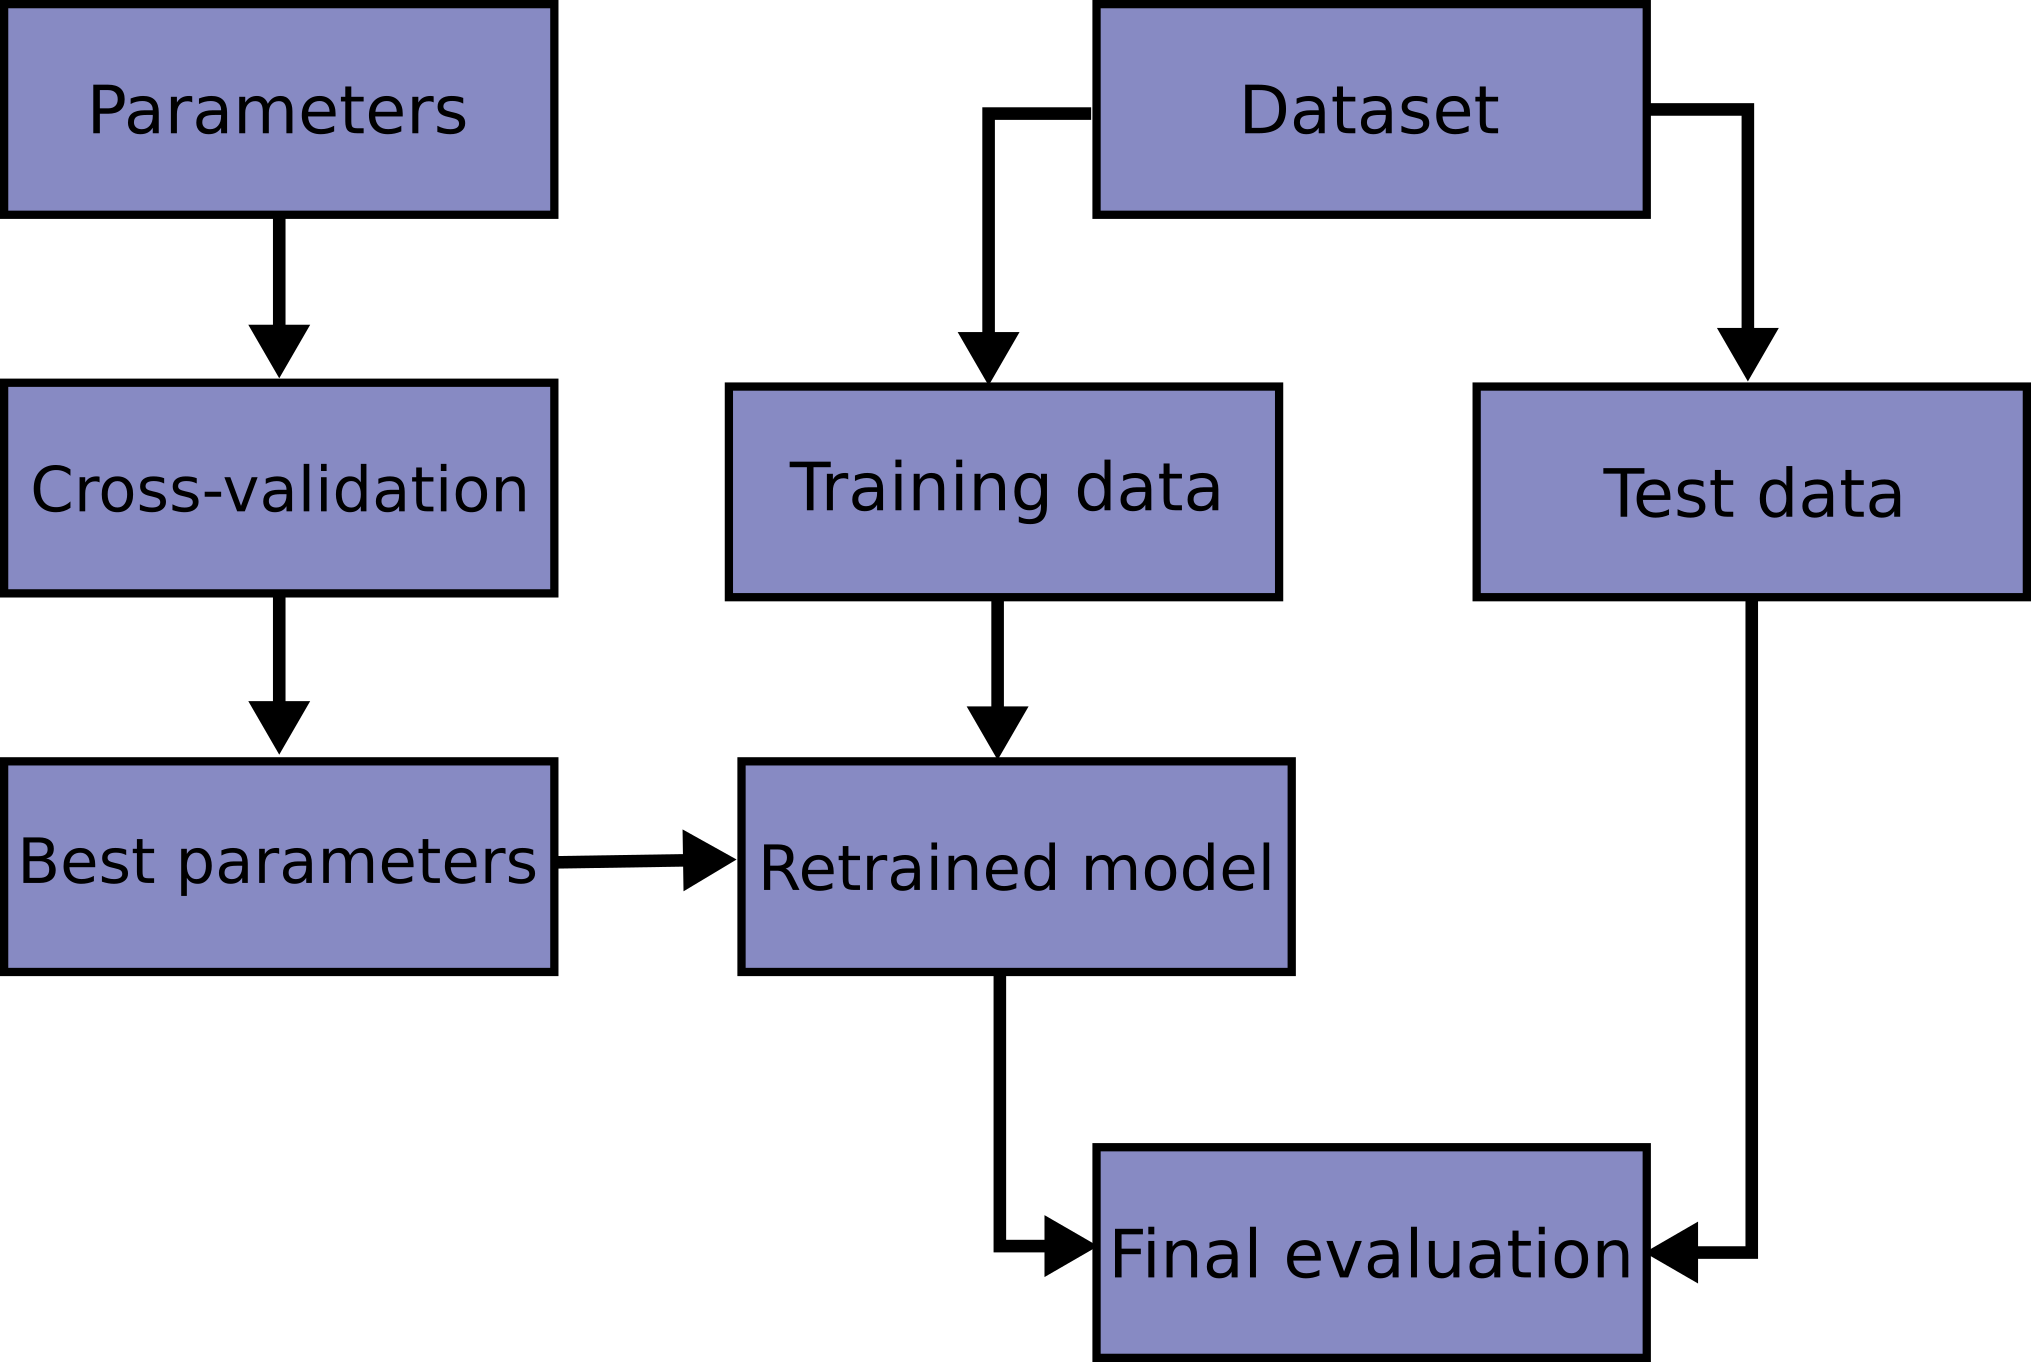

Hagamos un LOO-CV

In [ ]:
rmse_val=[]
wml=[]
for i in range(x_train.shape[0]):#voy a hacer N folds
  x_train_aux, t_train_aux = x_train[np.arange(x_train.shape[0])!=i], t_train[np.arange(t_train.shape[0])!=i]#me quedo con todos los elementos menos el i-esimo para entrenar
  x_val_aux, t_val_aux =x_train[i], t_train[i] # separo el elemento i-esimo para validar
  Phi_aux=np.hstack((x_train_aux*0.0+1.0,x_train_aux)) #matriz de disenio para entrenamiento
  pp1 = np.dot(Phi_aux.T, Phi_aux)
  yy = np.dot(Phi_aux.T, t_train_aux)
  wml_aux=np.linalg.solve(pp1, yy)#resuelvo las ecuaciones normales con el conjunto de entrenamiento
  wml.append(wml_aux)
  Phi_val_aux=np.hstack((x_val_aux*0.0+1.0,x_val_aux))#matriz de disenio para validacion
  y_val_aux=np.dot(Phi_val_aux,wml_aux)#prediccion para validacion
  rmse_val.append(np.sqrt(mse(t_val_aux, y_val_aux)))

In [ ]:
rmse_val

[0.3708649676336265,
 1.4807884540896,
 0.6220915217573059,
 0.6408327588500011,
 0.917552902351302,
 0.24291582840534676,
 0.6445590694386132,
 0.1676450068872013,
 0.3571739550611341,
 0.2901302099576968]

In [ ]:
print(wml)

[array([[ 0.86848832],
       [-2.2268792 ]]), array([[ 1.15810397],
       [-2.99707667]]), array([[ 0.9227191 ],
       [-2.14023877]]), array([[ 0.97178823],
       [-2.23097455]]), array([[ 0.65156947],
       [-1.91494189]]), array([[ 0.86132253],
       [-2.18850333]]), array([[ 1.17382284],
       [-2.61868409]]), array([[ 0.92001355],
       [-2.22240775]]), array([[ 0.95581609],
       [-2.2548024 ]]), array([[ 0.93428131],
       [-2.22628987]])]


In [ ]:
print("Media del RMSE:{}".format(np.mean(rmse_val)))
print("Desviacion estandar del RMSE:{}".format(np.sqrt(np.var(rmse_val,ddof=0))))

Media del RMSE:0.5734554674431827
Desviacion estandar del RMSE:0.37358392208081365


Comparemos con la implementacion de sklearn

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score?

In [ ]:
lr=LinearRegression(fit_intercept=True)
loo_cv=cross_val_score(lr,x_train,t_train,cv=x_train.shape[0],scoring='neg_root_mean_squared_error')
errores = -loo_cv
print(errores.mean(), errores.std())

0.5734554674431827 0.37358392208081376


Ahora, apliquemos esto al problema de decidir el mejor grado del polinomio:

In [ ]:
def cv_multimodel(grados=range(12), cv=len(x_train), plot=True):
        
    rsmes = np.zeros(len(grados))
    std_rsmes = np.zeros(len(grados))
    
    for i, grado in enumerate(grados):
        # Crea un pipeline de sklearn con features de grado "grado"
        modelo = Pipeline([('features', PolynomialFeatures(degree=grado)),#x->[1,x,x^2,..,x^grado]
                           ('regression', LinearRegression(fit_intercept=False))
                          ])
        
        # Hace K-folding
        scores = cross_val_score(modelo, x_train, t_train, cv=cv, scoring='neg_root_mean_squared_error')
            
        # Como se usa un score, hay que pasarlo a Error cambiando de signo.
        rsmes[i] = (-scores).mean()
        std_rsmes[i] = (-scores).std()
        
    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
        # Sin errores
        #ax.semilogy(grados, rsmes, 'o-', mfc='None')
        
        # Con errores
        ax.errorbar(grados, rsmes, std_rsmes, fmt='-o')
        ax.set_yscale('log')
        
        ax.set_xlabel('Grado')
        ax.set_ylabel('mean RMSE')
                
    return grados, rsmes, std_rsmes

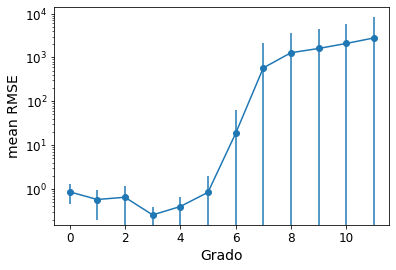

In [ ]:
grados, errors, errorst = cv_multimodel()

In [ ]:
print("El mejor grado es:{}".format(grados[np.argmin(errors)]))

El mejor grado es:3


Una vez decidimos el grado del polinomio, podemos ajustar **usando todos los datos de entrenamiento** y evaluar en el **conjunto de test**:

In [ ]:
# Definir el mejor modelo, elegido a partir de CV
modelo = Pipeline([('features', PolynomialFeatures(degree=3)),
                    ('regression', LinearRegression(fit_intercept=False))
                    ])
# Ajustar con mi conjunto de training.
modelo.fit(x_train, t_train)

# Evaluar en el conjunto de test.
y_test = modelo.predict(x_test)
print('El error del mejor modelo en el conjunto de test es {:.2e}.'.format(np.sqrt(mse(t_test, y_test))))

El error del mejor modelo en el conjunto de test es 2.73e-01.


Veamos la version scikit-learn de lo que acabamos de hacer

In [ ]:
from sklearn.model_selection import GridSearchCV
GridSearchCV?

In [ ]:
modelo = Pipeline([('features', PolynomialFeatures()),
                    ('regression', LinearRegression(fit_intercept=False))
                    ])
hyperparameters={'features__degree':[1,2,3,4,5,6,7,8,9,10,11]}
grilla=GridSearchCV(modelo,hyperparameters,refit=True)
grilla.fit(x_train,t_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('regression',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=False,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'features__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                                            

In [ ]:
print(grilla.best_params_)

{'features__degree': 3}


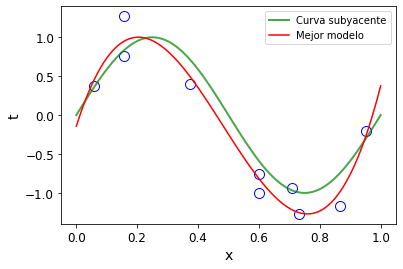

In [ ]:
elmejor=grilla.best_estimator_
plot_data_sine(x_train, t_train)
plt.plot(xx,elmejor.predict(xx),color='red',label='Mejor modelo')
plt.legend(loc='upper right')

In [ ]:
grilla.cv_results_

{'mean_fit_time': array([0.00084057, 0.00071912, 0.00064702, 0.00063276, 0.00074954,
        0.00102944, 0.00070782, 0.00066776, 0.000664  , 0.00069733,
        0.00068088]),
 'mean_score_time': array([0.00322227, 0.00058246, 0.00053325, 0.00053205, 0.00061474,
        0.00062165, 0.00058217, 0.00055594, 0.00055285, 0.00056467,
        0.00056992]),
 'mean_test_score': array([-1.40559029e+01, -7.92514541e+00, -3.04086415e+00, -4.43385294e+00,
        -2.76060988e+02, -7.32430308e+05, -1.55702536e+07, -2.07918240e+07,
        -3.54359067e+07, -6.71932222e+07, -1.29597164e+08]),
 'param_features__degree': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'features__degree': 1},
  {'features__degree': 2},
  {'features__degree': 3},
  {'features__degree': 4},
  {'features__degree': 5},
  {'features__degre

In [ ]:
grilla.cv_results_['param_features__degree'].data

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], dtype=object)

1 14.055902883331573
2 7.925145411302305
3 3.0408641516530013
4 4.433852938851844
5 276.0609884319455
6 732430.3075421548
7 15570253.581631785
8 20791823.96625226
9 35435906.7439497
10 67193222.17924996
11 129597164.13166316


Text(0, 0.5, 'RMSE en validacion')

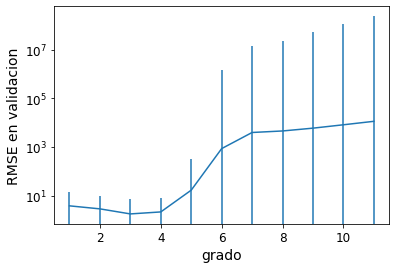

In [ ]:
for ni, i in enumerate(grilla.cv_results_['params']):
  print(i['features__degree'],-grilla.cv_results_['mean_test_score'][ni])
plt.errorbar(grilla.cv_results_['param_features__degree'].data,np.sqrt(-grilla.cv_results_['mean_test_score']),yerr=grilla.cv_results_['std_test_score'])
plt.yscale('log')
plt.xlabel('grado')
plt.ylabel('RMSE en validacion')

## Ejercicio

Hasta ahora, trabajamos con mediciones con un unico feature $x$ al que transformamos en polinomios. Otra situacion con la que nos podemos encontrar es una medicion con muchos features $x_{1},x_{2}, x_{3},...,x_{D}$. En este caso, el grado del polinomio aumenta la cantidad de coeficientes muy rapidamente. 

Para California, considere unicamente las categorias numericas:

In [ ]:
HOUSING_PATH = "datasets"
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [ ]:
import sys
if 'google.colab' in sys.modules:
        
    import tarfile

    DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/"
    HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

    !mkdir -p ./datasets/housing

    def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
        os.makedirs(housing_path, exist_ok=True)
        tgz_path = os.path.join(housing_path, "housing.tgz")
        #urllib.request.urlretrieve(housing_url, tgz_path)
        !wget {HOUSING_URL} -P {housing_path}
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()

    # Corramos la función
    fetch_housing_data()

else: 
    print("Not running on Google Colab. This cell is did not do anything.")

--2021-04-08 17:56:02--  https://github.com/ageron/handson-ml2/raw/master/datasets/housing/housing.tgz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz [following]
--2021-04-08 17:56:03--  https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 409488 (400K) [application/octet-stream]
Saving to: ‘datasets/housing.tgz’

housing.tgz         100%[===================>] 399.89K  --.-KB/s    in 0.07s   

2021-04-08 17:56:03 (5.86 MB/s) - ‘datasets/housing.tgz’ saved [4

In [ ]:
housing_pre = load_housing_data()
from sklearn.model_selection import StratifiedShuffleSplit

housing_pre["income_cat"] = pd.cut(housing_pre["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=445543)
for train_index, test_index in split.split(housing_pre, housing_pre["income_cat"]):
    california_housing_train = housing_pre.loc[train_index]
    california_housing_test = housing_pre.loc[test_index]

for set_ in (california_housing_train, california_housing_test):
    set_.drop("income_cat", axis=1, inplace=True)

In [ ]:
housing=california_housing_train.copy()

problematic_columns = ['median_house_value', 'housing_median_age', 'median_income']
max_values=[]
for col in problematic_columns:
    max_value = housing[col].max()
    print(f"{col}: {sum(housing[col] == max_value)} districts with {col} = {max_value} ({round(sum(housing[col] == max_value)/len(housing)*100,2)}%).")
    max_values.append(max_value)

housing_clean = housing.copy()
for col, max_value in zip(problematic_columns, max_values):
    housing_clean = housing_clean[housing_clean[col] != max_value]

housing_test=california_housing_test.copy()
housing_test_clean = housing_test.copy()
for col, max_value in zip(problematic_columns, max_values):
    housing_test_clean = housing_test_clean[housing_test_clean[col] != max_value]

median_house_value: 762 districts with median_house_value = 500001.0 (4.61%).
housing_median_age: 997 districts with housing_median_age = 52.0 (6.04%).
median_income: 42 districts with median_income = 15.0001 (0.25%).


In [ ]:
housing_clean["rooms_per_household"] = housing_clean["total_rooms"]/housing_clean["households"]
housing_clean["bedrooms_per_room"] = housing_clean["total_bedrooms"]/housing_clean["total_rooms"]
housing_clean["population_per_household"]=housing_clean["population"]/housing_clean["households"]

housing_test_clean["rooms_per_household"] = housing_test_clean["total_rooms"]/housing_test_clean["households"]
housing_test_clean["bedrooms_per_room"] = housing_test_clean["total_bedrooms"]/housing_test_clean["total_rooms"]
housing_test_clean["population_per_household"]=housing_test_clean["population"]/housing_test_clean["households"]

In [ ]:
housing_labels = housing_clean["median_house_value"].copy()
housing_clean = housing_clean.drop("median_house_value", axis=1) # drop labels for training set
housing_num = housing_clean.drop("ocean_proximity", axis=1)

housing_test_labels = housing_test_clean["median_house_value"].copy()
housing_test_clean = housing_test_clean.drop("median_house_value", axis=1) # drop labels for training set
housing_test_num = housing_test_clean.drop("ocean_proximity", axis=1)

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),#hay mas opciones aca
        ('std_scaler', StandardScaler()),
    ])

housing_num_transformed=num_pipeline.fit_transform(housing_num)
housing_test_num_transformed=num_pipeline.transform(housing_test_num)

Utilicen validacion cruzada para elegir el mejor polinomio para predecir el `median_house_value`. Para comparar las predicciones con los valores verdaderos, grafiquen una curva de $y$ vs $t$. Mientras mejor sea el modelo, mas cercano debera ser a la curva $y=t$.

In [ ]:
modelo = Pipeline([('features', PolynomialFeatures()),
                    ('regression', LinearRegression(fit_intercept=False))
                    ])
hyperparameters={'features__degree':[1,2,3]}
grilla=GridSearchCV(modelo,hyperparameters,refit=True,scoring='neg_mean_squared_error')
grilla.fit(housing_num_transformed,housing_labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('regression',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=False,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'features__degree': [1, 2, 3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_s

In [ ]:
print(np.sqrt(-grilla.cv_results_['mean_test_score']))

[5.96352375e+04 7.31217716e+04 2.01267589e+08]


(-200000.0, 600000.0)

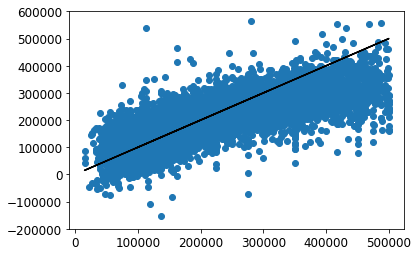

In [ ]:
plt.scatter(housing_labels,grilla.best_estimator_.predict(housing_num_transformed))
plt.plot(housing_labels,housing_labels,'black')
plt.ylim(-200000,600000)

In [ ]:
GridSearchCV?

In [ ]:
print(np.sqrt(-grilla.best_score_),np.sqrt(mse(grilla.best_estimator_.predict(housing_test_num_transformed),housing_test_labels)))

59635.23745537877 57654.49505865998


In [ ]:
grilla.best_estimator_['regression'].coef_

array([189605.05722345, -72351.52377654, -77278.16047354,   9653.45150832,
         1101.72155397,   3883.20092696, -36739.82220409,  36110.20454093,
        67103.70512648,   5936.00800587,  17846.57593934,   -397.42911188])

## RandomizedSearchCV

Al aumentar la cantidad de parametros posibles del modelo, y los valores considerados de cada parametro, el enfoque de `GridSearchCV` puede ser demasiado costoso. Conviene utilizar `RandomizedSearchCV` que elije un numero determinado de combinaciones al azar de los parametros.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

Para esto, necesitamos especificar la distribucion que sigue cada parametro. En el caso del grado de un polinomio, podemos utilizar una uniforme en todos los grados posibles, para lo que basta dar la lista de valores posibles.

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [ ]:
modelo = Pipeline([('features', PolynomialFeatures()),
                    ('regression', LinearRegression(fit_intercept=False))
                    ])

distributions={'features__degree':[1,2,3,4,5,6,7,8,9,10,11]}
grilla=RandomizedSearchCV(modelo,distributions,n_iter=5,refit=True)
grilla.fit(x_train,t_train)

In [ ]:
grilla.cv_results_['params']

Si tuviese otro parametro, podria darle una distribucion distinta de la uniforme (ya lo vamos a ver)

# Weighted Least Squares

Cuando discutimos la derivacion de regresion lineal, consideramos que todas las mediciones tenian el mismo error. Esto puede no ser cierto. Podemos incorporar los distintos errores utilizando WLS, asumiendo todavia mediciones independientes.

Si cada medicion $t_{n}$ tiene desviacion estandar $\sigma_{n}$ **conocida**, entonces la funcion a minimizar sera:

$E_{D}(\vec{w})=\sum_{n=1}^{N}\frac{(t_{n}-y(\vec{x}_{n},\vec{w}))^{2}}{\sigma^{2}_{n}}$

Con un poco de ojo critico, podemos definir las nuevas variables $t'=\frac{t}{\sigma}$ e $y'=\frac{y}{\sigma}$. Entonces, el algoritmo es identico al caso homocedastico pero en un nuevo espacio.

$E_{D}(\vec{w})=\sum_{n=1}^{N}(t^{'}_{n}-y^{'}(\vec{x}_{n},\vec{w}))^{2}$

Veamos un ejemplo. Supongamos que ahora los mismos datos tienen un error $\sqrt{|t|+0.001}$.

In [ ]:
t_train_scaled=t_train/np.sqrt(np.abs(t_train)+0.001)
Phi=np.hstack((1/np.sqrt(np.abs(t_train)+0.001),x_train/np.sqrt(np.abs(t_train)+0.001)))

In [ ]:
# Ahora calculemos el producto de phi por su transpuesta y verifiquemos que la forma es la correcta
pp1 = np.dot(Phi.T, Phi)
# y el producto entre Phi y el vector t
yy = np.dot(Phi.T, t_train)
wml = np.linalg.solve(pp1, yy)
print(wml)

Para hacer predicciones, volvemos al espacio de $y$ y $t$.

In [ ]:
Phi_preds=np.hstack((xx*0.0+1.0,xx))
preds_manual=np.dot(Phi_preds,wml)
# print(t_train.shape)
plt.errorbar(x_train[:,0], t_train[:,0], np.sqrt(np.abs(t_train)+0.001)[:,0], fmt='ob')#'ob', mfc='None', ms=10)
plt.plot(xx, np.sin(2*np.pi * xx),'g-', lw=2, alpha=0.7, label='Ground Truth')
plt.xlabel('x')
plt.ylabel('t')
plt.plot(xx, preds_manual, 'r-', label='Prediction')
plt.ylim(-2.5, 3.3)
plt.legend(loc=0)
plt.title('Grado {}'.format(1))

Estos tipos de fitteo van a buscar acomodar los puntos con menor error, ya que son los mas "seguros". 

`LinearRegression()` ofrece la opcion de poner un `sample_weight` a la hora de fittear.

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import Pipeline
import sklearn.preprocessing  as pp
from sklearn.linear_model import LinearRegression

# Creo el pipeline
pp_sine = Pipeline([('poly', pp.PolynomialFeatures()),
                     ('lr', LinearRegression(fit_intercept=False))])

# Inicializo listas
degrees = [1, 2, 3, 5, 7, 9, 11]
coeffs = []
rmse = []
rmse_test = []
preds = []
# Itero sobre los grados
for d in degrees:
    # Fijo el grado
    pp_sine.named_steps['poly'].degree = d
    
    # Fiteo (y registro los valores de los parámetros)
    error=np.append([0.00001],np.sqrt(np.abs(t_train)+0.001)[1:,0])
    pp_sine.fit(x_train, t_train,lr__sample_weight=list(map(lambda x: 1/x**2,error)))
    coeffs.append(pp_sine.named_steps['lr'].coef_)
    
    # Obtengo predicciones
    y_train = pp_sine.predict(x_train)
    y_test = pp_sine.predict(x_test)
    preds.append(pp_sine.predict(xx))

    # Calculo el RMSE    
    rmse.append(np.sqrt(mse(t_train, y_train)))
    rmse_test.append(np.sqrt(mse(t_test, y_test)))

In [ ]:
# Veamos cómo evoluciona la métrica con el número de grados de libertad
plt.figure(figsize=(10,4))
plt.plot(degrees, rmse, 'o-r', mfc='None', ms=10, mew=2, label='Train')
plt.plot(degrees, rmse_test, 'o-b', mfc='None', ms=10, mew=2,label='Test')
plt.xlabel('Grado de features polinomiales')
plt.ylabel('RMSE')
plt.yscale('log')
plt.legend(loc='upper right')
for i, d in enumerate(degrees):
    print(d, rmse[i], rmse_test[i])

In [ ]:
ncols = 3
nrows = np.int(np.ceil(len(degrees)/ncols))

fig = plt.figure(figsize=(12, 12))
plt.subplots_adjust(hspace=0.4)

for i, d in enumerate(degrees):
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.errorbar(x_train[:,0], t_train[:,0], np.append([0.00001],np.sqrt(np.abs(t_train)+0.001)[1:,0]), fmt='ob')#'ob', mfc='None', ms=10)
    ax.plot(xx, np.sin(2*np.pi * xx),'g-', lw=2, alpha=0.7, label='Ground Truth')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.plot(xx, preds[i], 'r-', label='Prediction')
    ax.set_ylim(-2.5, 3.3)
    ax.set_title('Grado {}'.format(d))